# Module 5

Question 4

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

### Import Libraries

In [1]:
from botocore.client import Config
import types
import ibm_boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

### Load Data
 - Combined Dataset

In [3]:
client_cred.download_file(Bucket=bucket,Key='combined_raw_cos.pkl',Filename='./combined_raw.pkl')
df = pd.read_pickle('./combined_raw.pkl')

In [4]:
df.head()

,created_date,complaint_type,incident_address,street_name,city,resolution_description,borough,latitude,longitude,closed_date,...,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode
21,2019-12-10T04:06:20.000,1,600 ROGERS AVENUE,ROGERS AVENUE,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,40.657111,-73.953171,2019-12-10T16:28:29.000,...,96.00,1.0,4.0,0.0,8760.0,2.43,0.0,1931.0,0.0,11225.0
38,2019-12-10T08:52:32.000,1,7 HEGEMAN AVENUE,HEGEMAN AVENUE,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,40.655591,-73.911863,2019-12-10T21:40:59.000,...,213.67,1.0,20.0,0.0,158620.0,2.43,0.0,1948.0,0.0,11212.0
55,2019-12-10T10:14:30.000,0,3100 OCEAN PARKWAY,OCEAN PARKWAY,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,40.575867,-73.968639,2019-12-10T20:12:36.000,...,200.00,1.0,6.0,0.0,160000.0,2.43,32000.0,1932.0,2013.0,11235.0
59,2019-12-10T06:19:29.000,1,433 BLEECKER STREET,BLEECKER STREET,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,40.703452,-73.912993,2019-12-10T21:40:58.000,...,100.00,1.0,4.0,0.0,7000.0,2.43,0.0,1931.0,0.0,11237.0
98,2019-12-09T13:43:15.000,1,1203 MYRTLE AVENUE,MYRTLE AVENUE,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,40.697358,-73.931971,2019-12-10T16:48:16.000,...,60.17,1.0,4.0,0.0,4620.0,2.43,1540.0,1931.0,0.0,11221.0


## Preprocessing

Use only columns that have the severe complaint per instructions

In [5]:
df = df[df['complaint_type'] == 1]

In [6]:
df.columns

Index(['created_date', 'complaint_type', 'incident_address', 'street_name',
       'city', 'resolution_description', 'borough', 'latitude', 'longitude',
       'closed_date', 'location_type', 'status', 'BldgArea', 'BldgDepth',
       'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR',
       'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode'],
      dtype='object')

Covert the created_date column to datetime and use as index for predictions

In [7]:
df['created_date'] = pd.to_datetime(df['created_date'])
df['created_date'] = df['created_date'].dt.date

In [8]:
df_time = df.groupby( by = 'created_date').count()

In [9]:
df_time.index = pd.to_datetime(df_time.index)

In [10]:
df_time = df_time['complaint_type']

## Visualize Time Series Data

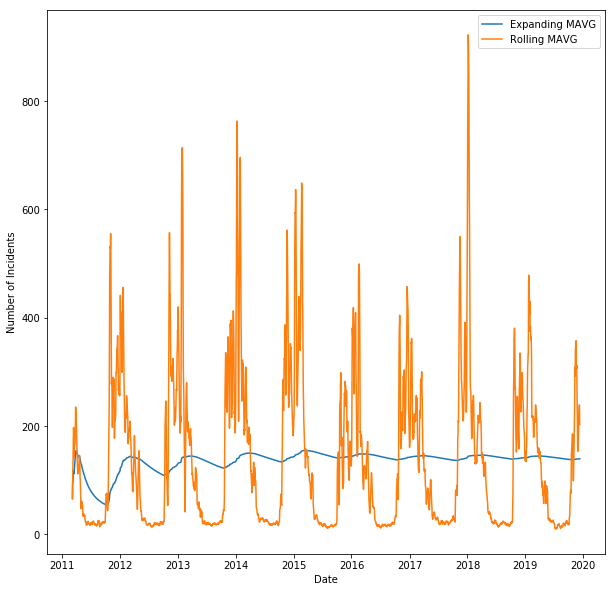

In [16]:
plt.figure(figsize = (10,10))
window_length = 10
smoothing_multiplier = 2/(window_length+1)
plt.plot(df_time.expanding(min_periods = window_length).mean(), label = 'Expanding MAVG')
plt.plot(df_time.rolling(window_length).mean(), label = 'Rolling MAVG')
plt.legend()
plt.xlabel("Date")
plt.ylabel('Number of Incidents');

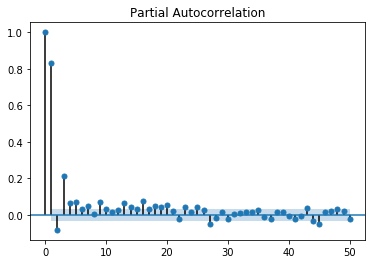

In [12]:
plot_pacf(df_time, lags = 50);

# Modeling
Split the model to training and test set

In [13]:
split = int(len(df_time)*.75)
train = df_time[: split] 
test = df_time[split:]

**Holt Winter Model**

In [14]:
h_w = ExponentialSmoothing(endog = train)
h_w = h_w.fit()
hw_training_predictions = h_w.predict(start =0 , end = (len(train)-1))
hw_testing_predictions = h_w.forecast(steps=len(test))

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [17]:
print('Holt Winter RMSE on Training Data is :',np.sqrt(mean_squared_error(train, hw_training_predictions)))
print('Holt Winter R2 on Training Data is :',r2_score(train, hw_training_predictions))
print(" ---------------------------------------")
print('Holt Winter RMSE on Test Data is :', np.sqrt(mean_squared_error(test, hw_testing_predictions)))
print('Holt Winter R2 on Test Data is :', r2_score(test, hw_testing_predictions))

Holt Winter RMSE on Training Data is : 104.27589529101746
Holt Winter R2 on Training Data is : 0.6532980133063876
 ---------------------------------------
Holt Winter RMSE on Test Data is : 208.64962158731245
Holt Winter R2 on Test Data is : -0.42467062239849973


In [18]:
sm = SARIMAX(endog = train, order=(2, 1, 4))
sm = sm.fit()
sarimax_training_predictions = sm.predict(start =0 , end = (len(train)-1))
sarimax_testing_predictions = sm.forecast(steps=len(test))

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [19]:
print('SARIMAX RMSE on Training Data is:', np.sqrt(mean_squared_error(train, sarimax_training_predictions)))
print('SARIMAX R2 on Training Data is:', r2_score(train, sarimax_training_predictions))
print(" ---------------------------------------")
print('SARIMAX RMSE on Test Data is:', np.sqrt(mean_squared_error(test, sarimax_testing_predictions)))
print('SARIMAX R2 on Test Data is:', r2_score(test, sarimax_testing_predictions))

SARIMAX RMSE on Training Data is: 95.65757932602811
SARIMAX R2 on Training Data is: 0.7082389932624429
 ---------------------------------------
SARIMAX RMSE on Test Data is: 212.16483526889238
SARIMAX R2 on Test Data is: -0.47307912482319403


**ARIMA Model**

In [20]:
ar = ARIMA(endog = train,
            order = (4,0,4))
ar = ar.fit()
arima_training_predictions = ar.predict(start =0 , end = (len(train)-1))
arima_testing_predictions = ar.forecast(steps=len(test))

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [21]:
print('ARIMA RMSE on Training Data is:', np.sqrt(mean_squared_error(train, arima_training_predictions)))
print('ARIMA R2 on Training Data is:', r2_score(train, sarimax_training_predictions))
print(" ---------------------------------------")
print('ARIMA RMSE on Test Data is:', np.sqrt(mean_squared_error(test, arima_testing_predictions[0])))
print('ARIMA R2 on Test Data is:', r2_score(test, arima_testing_predictions[0]))

ARIMA RMSE on Training Data is: 95.29544266609605
ARIMA R2 on Training Data is: 0.7082389932624429
 ---------------------------------------
ARIMA RMSE on Test Data is: 181.51942896338906
ARIMA R2 on Test Data is: -0.0782649777184341


## Conclusion

Models need more tuning and additional data. Weather data could greatly improve model performance. Current models do not do a good against unseen data.